## Gabe Gomez

#### A project using machine learning to detect pneumonia based off X-ray images

*Note: For this project, I'm mostly following what was done by Nain to learn  
*Link: https://www.kaggle.com/aakashnain/beating-everything-with-depthwise-convolution

In [18]:
%matplotlib inline
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import imgaug as aug
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
import cv2
import tensorflow as tf
from keras import backend as K

## Making things as reproducible as possible

In [3]:
# Disable multi-threading in tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

# Define a tensorflow session with above session configs
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

# Set the session in keras
K.set_session(sess)

# Make the augmentation sequence deterministic
aug.seed(111)

## Getting ready to import images

In [8]:
path = os.getcwd() + '/data/chest_xray/'
train_path = path + 'pneumonia_train'
test_path = path + 'pnuemonia_test'
val_path = path + 'val'

In [9]:
normal_train_path = train_path + '/NORMAL'
pneumonia_train_path = train_path + '/PNEUMONIA'

In [11]:
normal_case = os.listdir(normal_train_path)
pneumonia_case = os.listdir(pneumonia_train_path)

In [12]:
train_data = []

# Giving normal cases a label of 0
for img in normal_case:
    train_data.append((img, 0))
    
# Giving pneumonia cases a label of 1
for img in pneumonia_case:
    train_data.append((img,1))
    
# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,NORMAL2-IM-0650-0001.jpeg,0
1,person430_bacteria_1871.jpeg,1
2,person920_virus_1577.jpeg,1
3,NORMAL2-IM-0814-0001.jpeg,0
4,person799_bacteria_2705.jpeg,1


## Performing some EDA

1    3876
0    1342
Name: label, dtype: int64


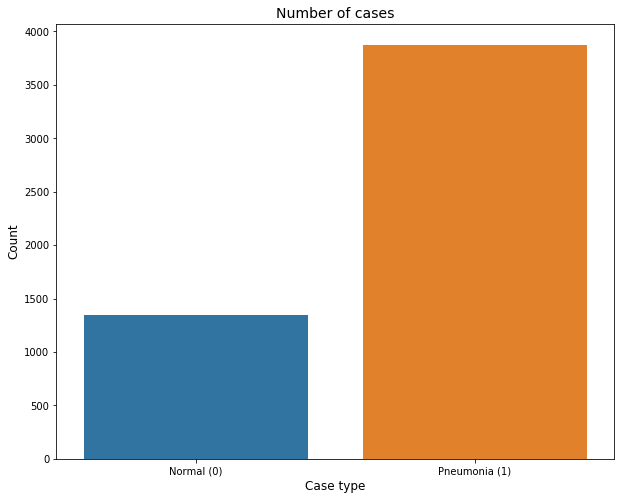

In [16]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal (0)', 'Pneumonia (1)'])
plt.show()

# As we can see, more cases of pneumonia than not. This could be beneficial to us in the end as most datasets I have
# worked with have less positive cases than not.

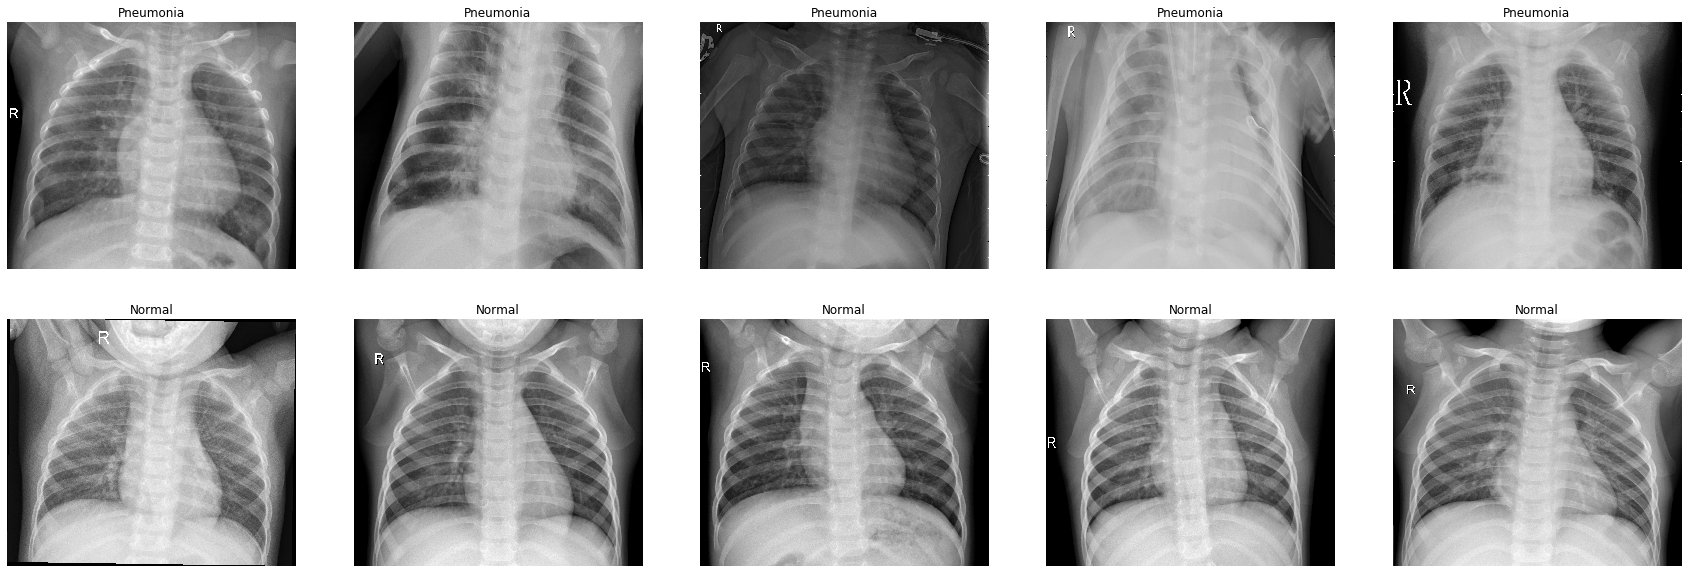

In [23]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    if i<5:
        img = imread(pneumonia_train_path + '/' + samples[i])
        ax[i//5, i%5].imshow(img, cmap='gray')
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        img = imread(normal_train_path + '/' + samples[i])
        ax[i//5, i%5].imshow(img, cmap='gray')
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

## Setting up validation data